In [ ]:

# Install required packages
!pip install -q langgraph langchain-google-genai playwright
!playwright install chromium
!playwright install-deps

print("✅ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.2 which is incompatible.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but yo

In [ ]:

import os
import json
import time
import getpass
import asyncio
import nest_asyncio  # Add this line
from typing import TypedDict, Annotated, Literal, List, Dict
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from playwright.async_api import async_playwright, Page
import operator

# Apply nest_asyncio to allow nested event loops in Colab
nest_asyncio.apply()

print("✅ Libraries imported and nest_asyncio applied!")

✅ Libraries imported and nest_asyncio applied!


In [ ]:

# Get API key for Gemini 2.5 Pro
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API key: ")

# Initialize the LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0)

print(f"✅ Gemini 2.5 Pro initialized!")

Enter your Google API key: ··········
✅ Gemini 2.5 Pro initialized!


In [ ]:

class ArticleScraperState(TypedDict):
    """State that flows through the LangGraph"""
    target_url: str  # URL to scrape
    target_count: int  # Number of articles to collect
    articles: List[Dict]  # Collected articles
    current_url: str  # Current page URL
    page_content: str  # Content of current page
    navigation_plan: str  # Plan for finding articles
    next_action: str  # Next action to take
    error_message: str  # Any errors encountered
    retry_count: int  # Number of retry attempts
    messages: Annotated[list, operator.add]  # Conversation history

print("✅ State schema defined!")

✅ State schema defined!


In [ ]:

async def analyze_page_structure(page: Page) -> Dict:
    """Analyze the page structure using Playwright"""
    try:
        # Get page structure
        structure = {
            "title": await page.title(),
            "url": page.url,
            "menu_items": [],
            "article_links": [],
            "load_more_button": None,
            "pagination": None,
            "headings": []
        }

        # Find menu items with more selectors
        menu_selectors = [
            "nav a", ".menu a", ".navigation a",
            "#menu a", ".nav-menu a", "header a",
            ".main-menu a", ".top-menu a", ".primary-menu a",
            "ul.menu a", "ul.nav a", ".navbar a",
            ".nav-item a", ".menu-item a", ".site-nav a"
        ]

        for selector in menu_selectors:
            try:
                elements = await page.query_selector_all(selector)
                if elements:
                    structure["menu_items"] = [
                        {"text": (await el.text_content()).strip(), "href": await el.get_attribute("href")}
                        for el in elements if (await el.text_content()).strip()
                    ]
                    if structure["menu_items"]:
                        break
            except Exception as e:
                print(f"Error with selector {selector}: {str(e)}")
                continue

        # Enhanced article link detection
        article_selectors = [
            "article a", ".post a", ".entry-title a",
            ".article a", "h2 a", "h3 a", ".title a",
            ".blog-post a", ".news-item a", ".publication a",
            ".resource-item a", ".insight-item a",
            "a[href*='article']", "a[href*='post']", "a[href*='news']",
            ".content a", ".main-content a"
        ]

        for selector in article_selectors:
            try:
                elements = await page.query_selector_all(selector)
                if elements:
                    structure["article_links"] = [
                        {"text": (await el.text_content()).strip(), "href": await el.get_attribute("href")}
                        for el in elements if (await el.text_content()).strip()
                    ]
                    if structure["article_links"]:
                        break
            except Exception as e:
                print(f"Error with article selector {selector}: {str(e)}")
                continue

        # Get headings for context
        try:
            headings = await page.query_selector_all("h1, h2, h3")
            structure["headings"] = [await h.text_content() for h in headings if await h.text_content()]
        except Exception as e:
            print(f"Error getting headings: {str(e)}")

        # Check for load more button
        load_more_selectors = [
            ".load-more", ".more-posts", ".show-more",
            "[aria-label*='more']", "[title*='more']",
            ".btn-load-more", ".view-more", ".read-more"
        ]

        for selector in load_more_selectors:
            try:
                element = await page.query_selector(selector)
                if element:
                    structure["load_more_button"] = {
                        "text": (await element.text_content()).strip(),
                        "selector": selector
                    }
                    break
            except Exception as e:
                print(f"Error with load more selector {selector}: {str(e)}")
                continue

        # Check for pagination
        pagination_selectors = [
            ".pagination", ".page-numbers", ".nav-links",
            "[class*='pagin']", "[id*='pagin']",
            ".wp-pagenavi", ".pagination-wrapper"
        ]

        for selector in pagination_selectors:
            try:
                element = await page.query_selector(selector)
                if element:
                    structure["pagination"] = {
                        "selector": selector,
                        "html": await element.inner_html()
                    }
                    break
            except Exception as e:
                print(f"Error with pagination selector {selector}: {str(e)}")
                continue

        return structure
    except Exception as e:
        print(f"Error in analyze_page_structure: {str(e)}")
        return {"error": str(e)}

async def extract_article_content(page: Page) -> Dict:
    """Extract content from an article page"""
    try:
        article_data = {
            "title": "",
            "author": "",
            "date": "",
            "content": "",
            "url": page.url
        }

        # Extract title
        title_selectors = ["h1", ".post-title", ".entry-title", ".article-title"]
        for selector in title_selectors:
            try:
                element = await page.query_selector(selector)
                if element:
                    article_data["title"] = (await element.text_content()).strip()
                    break
            except Exception as e:
                print(f"Error with title selector {selector}: {str(e)}")
                continue

        # Extract author
        author_selectors = [".author", ".byline", ".post-author", "[rel='author']"]
        for selector in author_selectors:
            try:
                element = await page.query_selector(selector)
                if element:
                    article_data["author"] = (await element.text_content()).strip()
                    break
            except Exception as e:
                print(f"Error with author selector {selector}: {str(e)}")
                continue

        # Extract date
        date_selectors = [".date", ".post-date", ".entry-date", "time"]
        for selector in date_selectors:
            try:
                element = await page.query_selector(selector)
                if element:
                    article_data["date"] = (await element.text_content()).strip()
                    break
            except Exception as e:
                print(f"Error with date selector {selector}: {str(e)}")
                continue

        # Extract content
        content_selectors = [".content", ".entry-content", ".post-content", ".article-content"]
        for selector in content_selectors:
            try:
                element = await page.query_selector(selector)
                if element:
                    article_data["content"] = (await element.text_content()).strip()
                    break
            except Exception as e:
                print(f"Error with content selector {selector}: {str(e)}")
                continue

        return article_data
    except Exception as e:
        print(f"Error in extract_article_content: {str(e)}")
        return {"error": str(e), "url": page.url}

async def handle_lazy_loading(page: Page, max_scrolls: int = 5) -> bool:
    """Handle lazy loading by scrolling down the page"""
    try:
        previous_height = 0
        current_height = await page.evaluate("document.body.scrollHeight")
        scrolls = 0

        while scrolls < max_scrolls and previous_height != current_height:
            # Scroll to bottom
            await page.evaluate("window.scrollTo(0, document.body.scrollHeight)")

            # Wait for new content to load
            await asyncio.sleep(2)

            # Check if new content loaded
            previous_height = current_height
            current_height = await page.evaluate("document.body.scrollHeight")
            scrolls += 1

        return scrolls > 0
    except Exception as e:
        print(f"Error handling lazy loading: {str(e)}")
        return False

print("✅ Enhanced async helper functions defined!")

✅ Enhanced async helper functions defined!


In [ ]:

async def explorer_node(state: ArticleScraperState) -> ArticleScraperState:
    """Explorer Agent: Analyzes the website and finds articles"""
    print("🔵 Explorer Agent: Analyzing website structure...")

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        try:
            # Set longer timeout for slow websites
            page.set_default_timeout(60000)  # 60 seconds

            # Navigate to the target URL with retry logic
            max_retries = 3
            for attempt in range(max_retries):
                try:
                    print(f"🔵 Attempt {attempt + 1}/{max_retries} to load {state['target_url']}")
                    await page.goto(state["target_url"], timeout=60000)
                    await page.wait_for_load_state('domcontentloaded', timeout=60000)
                    break
                except Exception as e:
                    print(f"🔵 Error loading page (attempt {attempt + 1}): {str(e)}")
                    if attempt == max_retries - 1:
                        # Last attempt failed, return error
                        await browser.close()
                        return {
                            **state,
                            "error_message": f"Failed to load website after {max_retries} attempts: {str(e)}",
                            "messages": [{"role": "explorer", "content": f"Failed to load website: {str(e)}"}]
                        }
                    await asyncio.sleep(2)  # Wait before retrying

            # Wait a bit more for any dynamic content to load
            await asyncio.sleep(3)

            # Analyze page structure
            structure = await analyze_page_structure(page)

            # If we got an error structure, return it
            if "error" in structure:
                await browser.close()
                return {
                    **state,
                    "error_message": structure["error"],
                    "messages": [{"role": "explorer", "content": f"Error analyzing page: {structure['error']}"}]
                }

            # Print what we found for debugging
            print(f"🔵 Found {len(structure.get('menu_items', []))} menu items")
            print(f"🔵 Found {len(structure.get('article_links', []))} article links")
            print(f"🔵 Headings: {structure.get('headings', [])[:5]}")  # Show first 5 headings

            # Helper function to convert relative URLs to absolute
            def make_absolute_url(url):
                if url.startswith(('http://', 'https://')):
                    return url
                elif url.startswith('//'):
                    return f"https:{url}"
                elif url.startswith('/'):
                    base_url = state["target_url"].rstrip('/')
                    return f"{base_url}{url}"
                else:
                    base_url = state["target_url"].rstrip('/')
                    return f"{base_url}/{url}"

            # Use LLM to intelligently select the best menu item
            print("🔵 Using LLM to analyze menu items...")

            # Prepare menu items for LLM analysis
            menu_items_text = []
            for item in structure.get("menu_items", []):
                menu_items_text.append(f"- {item['text']}: {item['href']}")

            prompt = f"""You are an expert web scraper. Your task is to find the menu item that leads to articles, blog posts, or news articles on this website.

Target URL: {state['target_url']}
Target: Find {state['target_count']} articles

Menu Items Found:
{chr(10).join(menu_items_text)}

Current Page Article Links: {len(structure.get('article_links', []))}

Analyze the menu items and determine which one is MOST LIKELY to lead to a page with multiple articles. Consider:
1. Look for keywords like "articles", "article", "blog", "news", "resources", "publications"
2. Prioritize "articles" over "newsletter" or other less relevant terms
3. If you see "GEM Articles" or similar, that's likely the best choice
4. Avoid menu items that lead to contact pages, about pages, or single article pages

Return the EXACT text of the best menu item to click, or "NONE" if no good option is found."""

            response = await llm.ainvoke([{"role": "user", "content": prompt}])
            best_menu_text = response.content.strip()

            print(f"🔵 LLM selected menu item: {best_menu_text}")

            # Find the selected menu item
            selected_menu_item = None
            if best_menu_text != "NONE":
                for item in structure.get("menu_items", []):
                    if best_menu_text.lower() in item["text"].lower():
                        selected_menu_item = item
                        break

            # Also create a prioritized list of fallback options
            fallback_options = []
            for item in structure.get("menu_items", []):
                href = item.get("href", "").lower()
                text = item.get("text", "").lower()

                # Prioritize by keywords
                if "articles" in text:
                    fallback_options.append((10, item))
                elif "article" in text:
                    fallback_options.append((9, item))
                elif "blog" in text:
                    fallback_options.append((8, item))
                elif "news" in text:
                    fallback_options.append((7, item))
                elif "resources" in text:
                    fallback_options.append((6, item))
                elif "publications" in text:
                    fallback_options.append((5, item))
                elif "gem-" in href and any(word in href for word in ["article", "news", "blog"]):
                    fallback_options.append((4, item))

            # Sort fallback options by priority
            fallback_options.sort(key=lambda x: x[0], reverse=True)

            # Try to navigate to the best option
            navigation_plan = {
                "menu_item_to_click": None,
                "strategy": "scroll",
                "confidence": 0.3,
                "next_action": "scrape_articles"
            }

            # Function to validate a page has enough articles
            async def validate_articles_page(test_page, min_articles=5):
                try:
                    # Wait for content to load
                    await asyncio.sleep(2)
                    test_structure = await analyze_page_structure(test_page)
                    article_count = len(test_structure.get("article_links", []))
                    print(f"🔵 Validation: Found {article_count} article links (min required: {min_articles})")
                    return article_count >= min_articles
                except Exception as e:
                    print(f"🔵 Validation error: {str(e)}")
                    return False

            # Try the LLM-selected menu item first
            if selected_menu_item:
                print(f"🔵 Trying LLM-selected menu item: {selected_menu_item['text']}")

                try:
                    # Try clicking the menu item
                    await page.click(f"a:text-is('{selected_menu_item['text']}')")
                    await asyncio.sleep(3)

                    # Check if URL changed
                    if page.url != state["target_url"]:
                        print(f"🔵 Navigated to: {page.url}")

                        # Validate this page has articles
                        if await validate_articles_page(page):
                            print(f"🔵 Page validated as articles page!")
                            state["current_url"] = page.url

                            navigation_plan = {
                                "menu_item_to_click": selected_menu_item["text"],
                                "strategy": "scroll",
                                "confidence": 0.9,
                                "next_action": "scrape_articles"
                            }
                        else:
                            print(f"🔵 Page doesn't have enough articles, going back")
                            await page.go_back()
                            await asyncio.sleep(2)
                    else:
                        print(f"🔵 Click didn't change URL")
                except Exception as e:
                    print(f"🔵 Error clicking LLM-selected menu: {str(e)}")

            # If LLM selection didn't work, try fallback options
            if navigation_plan["confidence"] < 0.8:
                print(f"🔵 Trying fallback options...")

                for priority, item in fallback_options:
                    if navigation_plan["confidence"] >= 0.8:
                        break

                    print(f"🔵 Trying fallback option (priority {priority}): {item['text']}")

                    try:
                        # Try direct URL navigation
                        href = item.get("href", "")
                        absolute_url = make_absolute_url(href)

                        print(f"🔵 Navigating to: {absolute_url}")
                        await page.goto(absolute_url, timeout=60000)
                        await asyncio.sleep(2)

                        # Validate this page has articles
                        if await validate_articles_page(page):
                            print(f"🔵 Found valid articles page: {absolute_url}")
                            state["current_url"] = page.url

                            navigation_plan = {
                                "menu_item_to_click": item["text"],
                                "strategy": "scroll",
                                "confidence": 0.8,
                                "next_action": "scrape_articles"
                            }
                            break
                        else:
                            print(f"🔵 Page doesn't have enough articles")
                    except Exception as e:
                        print(f"🔵 Error with fallback option: {str(e)}")
                        continue

            # If still no good option, try common URL patterns
            if navigation_plan["confidence"] < 0.8:
                print(f"🔵 Trying common URL patterns...")

                common_patterns = [
                    "/articles",
                    "/article",
                    "/blog",
                    "/news",
                    "/resources",
                    "/publications",
                    "/gem-articles",  # The correct one we know
                    "/gem-news",
                    "/media",
                    "/insights"
                ]

                for pattern in common_patterns:
                    if navigation_plan["confidence"] >= 0.8:
                        break

                    try:
                        test_url = make_absolute_url(pattern)
                        print(f"🔵 Trying URL pattern: {test_url}")

                        await page.goto(test_url, timeout=60000)
                        await asyncio.sleep(2)

                        if await validate_articles_page(page):
                            print(f"🔵 Found valid articles page: {test_url}")
                            state["current_url"] = page.url

                            navigation_plan = {
                                "menu_item_to_click": None,
                                "strategy": "scroll",
                                "confidence": 0.8,
                                "next_action": "scrape_articles"
                            }
                            break
                    except Exception as e:
                        print(f"🔵 Error with URL pattern {pattern}: {str(e)}")
                        continue

            # Store the page content
            state["page_content"] = await page.content()

            await browser.close()

            return {
                **state,
                "navigation_plan": json.dumps(navigation_plan),
                "next_action": navigation_plan.get("next_action", "scrape_articles"),
                "messages": [{"role": "explorer", "content": f"Analyzed website and created navigation plan with confidence {navigation_plan.get('confidence', 0)}"}]
            }
        except Exception as e:
            await browser.close()
            return {
                **state,
                "error_message": str(e),
                "messages": [{"role": "explorer", "content": f"Error: {str(e)}"}]
            }

async def scraper_node(state: ArticleScraperState) -> ArticleScraperState:
    """Scraper Agent: Extracts articles from the page"""
    print("🟢 Scraper Agent: Extracting articles...")

    # Check if we already have enough articles
    if len(state.get("articles", [])) >= state.get("target_count", 0):
        print("🟢 Already have enough articles, skipping...")
        return {
            **state,
            "next_action": "complete",
            "messages": [{"role": "scraper", "content": "Target already reached, skipping extraction"}]
        }

    # Increment retry count
    retry_count = state.get("retry_count", 0) + 1

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        try:
            # Set longer timeout for slow websites
            page.set_default_timeout(60000)  # 60 seconds

            # Navigate to the current URL with retry logic
            max_retries = 3
            for attempt in range(max_retries):
                try:
                    print(f"🟢 Attempt {attempt + 1}/{max_retries} to load {state['current_url']}")
                    await page.goto(state["current_url"], timeout=60000)
                    await page.wait_for_load_state('domcontentloaded', timeout=60000)
                    break
                except Exception as e:
                    print(f"🟢 Error loading page (attempt {attempt + 1}): {str(e)}")
                    if attempt == max_retries - 1:
                        # Last attempt failed, return error
                        await browser.close()
                        return {
                            **state,
                            "error_message": f"Failed to load page after {max_retries} attempts: {str(e)}",
                            "next_action": "complete",
                            "retry_count": retry_count,
                            "messages": [{"role": "scraper", "content": f"Failed to load page: {str(e)}"}]
                        }
                    await asyncio.sleep(2)  # Wait before retrying

            # Wait a bit more for any dynamic content to load
            await asyncio.sleep(3)

            # Handle lazy loading if needed
            navigation_plan = json.loads(state["navigation_plan"])
            if navigation_plan.get("strategy") == "scroll":
                await handle_lazy_loading(page)

            # Get updated page structure
            structure = await analyze_page_structure(page)

            # Extract article links
            article_links = structure.get("article_links", [])
            print(f"🟢 Found {len(article_links)} article links on page")

            # If we don't have enough articles, try to find more using different selectors
            if len(article_links) < 5:
                print(f"🟢 Only found {len(article_links)} article links, trying additional selectors")

                # Use LLM to help find more article links
                page_content = await page.content()

                prompt = f"""You are a web scraping expert. I need to find article links on this page.

Current URL: {state['current_url']}
Target: {state['target_count']} articles
Currently found: {len(article_links)} article links

Page Content (first 2000 chars):
{page_content[:2000]}

Analyze the page content and suggest additional CSS selectors that might find more article links. Look for:
1. Article cards, post cards, blog cards
2. News items, resource items
3. Any elements that link to individual articles

Return 3-5 additional CSS selectors, one per line, that might find more article links."""

                try:
                    response = await llm.ainvoke([{"role": "user", "content": prompt}])
                    additional_selectors = [s.strip() for s in response.content.split('\n') if s.strip()]

                    print(f"🟢 LLM suggested additional selectors: {additional_selectors}")

                    for selector in additional_selectors:
                        try:
                            elements = await page.query_selector_all(selector)
                            if elements:
                                additional_links = [
                                    {"text": (await el.text_content()).strip(), "href": await el.get_attribute("href")}
                                    for el in elements if (await el.text_content()).strip()
                                ]
                                print(f"🟢 Found {len(additional_links)} additional links with selector: {selector}")
                                article_links.extend(additional_links)
                        except Exception as e:
                            print(f"🟢 Error with LLM-suggested selector {selector}: {str(e)}")
                            continue
                except Exception as e:
                    print(f"🟢 Error getting LLM suggestions: {str(e)}")

            # Remove duplicates and URLs we've already processed
            unique_links = []
            seen_urls = set()
            existing_urls = {article.get("url", "") for article in state.get("articles", [])}

            for link in article_links:
                if link["href"] and link["href"] not in seen_urls and link["href"] not in existing_urls:
                    unique_links.append(link)
                    seen_urls.add(link["href"])

            print(f"🟢 Found {len(unique_links)} new unique article links")

            # Graceful handling for no articles found
            if len(unique_links) == 0:
                print(f"🟢 No articles found on this page")

                # If we've tried everything and still found nothing
                if retry_count >= 3:
                    print(f"🟢 No articles found after {retry_count} attempts")

                    await browser.close()

                    return {
                        **state,
                        "next_action": "complete",
                        "retry_count": retry_count,
                        "error_message": "I didn't find any articles on this website",
                        "messages": [{"role": "scraper", "content": "I didn't find any articles on this website"}]
                    }

                # Try going back to explorer to find a better page
                print(f"🟢 Going back to explorer to find a better articles page")

                await browser.close()

                return {
                    **state,
                    "next_action": "explorer",
                    "retry_count": retry_count,
                    "messages": [{"role": "scraper", "content": "No articles found, going back to explorer"}]
                }

            # Determine how many new articles we need
            articles_needed = state["target_count"] - len(state["articles"])
            articles_to_scrape = min(articles_needed, len(unique_links))

            print(f"🟢 Need {articles_needed} more articles, will scrape {articles_to_scrape}")

            # Scrape articles
            new_articles = []
            for i in range(articles_to_scrape):
                link = unique_links[i]
                print(f"🟢 Scraping article {i+1}/{articles_to_scrape}: {link['text'][:50]}...")

                # Open a new page for each article
                article_page = await browser.new_page()
                article_page.set_default_timeout(60000)  # Set timeout for article pages too

                try:
                    await article_page.goto(link["href"], timeout=60000)
                    await article_page.wait_for_load_state('domcontentloaded', timeout=60000)

                    # Extract article content
                    article_data = await extract_article_content(article_page)
                    article_data["link_text"] = link["text"]

                    new_articles.append(article_data)
                    print(f"🟢 Successfully scraped article: {article_data.get('title', 'No title')[:50]}...")
                except Exception as e:
                    print(f"🟢 Error scraping article {link['href']}: {str(e)}")
                finally:
                    await article_page.close()

            # Update state with new articles
            updated_articles = state["articles"] + new_articles
            print(f"🟢 Total articles collected: {len(updated_articles)}")

            # Determine next action
            if len(updated_articles) >= state["target_count"]:
                next_action = "complete"
                print(f"🟢 Target reached, completing workflow")
            elif navigation_plan.get("strategy") == "load_more" and structure.get("load_more_button"):
                next_action = "load_more"
                print(f"🟢 Will try load more button")
            elif navigation_plan.get("strategy") == "pagination" and structure.get("pagination"):
                next_action = "next_page"
                print(f"🟢 Will try pagination")
            else:
                # If we haven't reached the target but don't have load more or pagination,
                # try to find a way to get more articles
                if len(updated_articles) < state["target_count"] and retry_count < 3:
                    print(f"🟢 Haven't reached target but no load more option, trying to find more articles")

                    # Try to find other articles sections
                    next_action = "explorer"
                else:
                    next_action = "complete"
                    print(f"🟢 No more content loading options, completing workflow")

            await browser.close()

            return {
                **state,
                "articles": updated_articles,
                "next_action": next_action,
                "retry_count": retry_count,
                "messages": [{"role": "scraper", "content": f"Scraped {len(new_articles)} articles, total: {len(updated_articles)}"}]
            }
        except Exception as e:
            await browser.close()
            print(f"🟢 Error in scraper: {str(e)}")
            return {
                **state,
                "error_message": str(e),
                "next_action": "complete",  # Don't loop on error
                "retry_count": retry_count,
                "messages": [{"role": "scraper", "content": f"Error: {str(e)}"}]
            }

async def load_more_node(state: ArticleScraperState) -> ArticleScraperState:
    """Load More Agent: Handles load more buttons"""
    print("🟡 Load More Agent: Loading more articles...")

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        try:
            # Navigate to the current URL
            await page.goto(state["current_url"], timeout=60000)
            await page.wait_for_load_state('networkidle', timeout=60000)

            # Get page structure
            structure = await analyze_page_structure(page)

            # Find and click load more button
            load_more_info = structure.get("load_more_button")
            if load_more_info:
                # Click the load more button
                await page.click(load_more_info["selector"])

                # Wait for new content to load
                await asyncio.sleep(3)

                # Update current URL if it changed
                state["current_url"] = page.url

                # Store the page content
                state["page_content"] = await page.content()

            await browser.close()

            return {
                **state,
                "next_action": "scrape_articles",
                "messages": [{"role": "load_more", "content": "Clicked load more button"}]
            }
        except Exception as e:
            await browser.close()
            return {
                **state,
                "error_message": str(e),
                "next_action": "scrape_articles",
                "messages": [{"role": "load_more", "content": f"Error: {str(e)}"}]
            }

async def next_page_node(state: ArticleScraperState) -> ArticleScraperState:
    """Next Page Agent: Handles pagination"""
    print("🟣 Next Page Agent: Navigating to next page...")

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        try:
            # Navigate to the current URL
            await page.goto(state["current_url"], timeout=60000)
            await page.wait_for_load_state('networkidle', timeout=60000)

            # Get page structure
            structure = await analyze_page_structure(page)

            # Find pagination element
            pagination_info = structure.get("pagination")
            if pagination_info:
                # Look for next page link
                next_page_selectors = [
                    ".next", ".page-numbers .next", "a.next",
                    ".pagination .next", "[aria-label='Next']"
                ]

                next_page_found = False
                for selector in next_page_selectors:
                    next_page_link = await page.query_selector(selector)
                    if next_page_link:
                        # Click the next page link
                        await next_page_link.click()
                        await page.wait_for_load_state('networkidle', timeout=60000)

                        # Update current URL
                        state["current_url"] = page.url

                        # Store the page content
                        state["page_content"] = await page.content()

                        next_page_found = True
                        break

                if not next_page_found:
                    # No more pages
                    state["next_action"] = "complete"
            else:
                # No pagination found
                state["next_action"] = "complete"

            await browser.close()

            return {
                **state,
                "messages": [{"role": "next_page", "content": "Navigated to next page"}]
            }
        except Exception as e:
            await browser.close()
            return {
                **state,
                "error_message": str(e),
                "next_action": "complete",
                "messages": [{"role": "next_page", "content": f"Error: {str(e)}"}]
            }

print("✅ Enhanced async agent nodes defined!")

✅ Enhanced async agent nodes defined!


In [ ]:

def decide_next_action(state: ArticleScraperState) -> Literal["explorer", "scraper", "load_more", "next_page", "end"]:
    """Decide what action to take next"""
    next_action = state.get("next_action", "")
    articles_collected = len(state.get("articles", []))
    target_count = state.get("target_count", 0)

    print(f"🔀 Decision Logic:")
    print(f"  - Next action from state: '{next_action}'")
    print(f"  - Articles collected: {articles_collected}")
    print(f"  - Target count: {target_count}")

    # Safety check: if we have enough articles, end
    if articles_collected >= target_count:
        print(f"  ✅ Target reached, ending workflow")
        return "end"

    # If we've tried scraping multiple times and aren't making progress, end
    retry_count = state.get("retry_count", 0)
    if retry_count > 5:
        print(f"  ⚠️ Too many retries ({retry_count}), ending workflow")
        return "end"

    # Check explicit next_action
    if next_action == "complete":
        print(f"  ✅ Action marked as complete, ending workflow")
        return "end"
    elif next_action == "explorer":
        print(f"  ➡️ Moving to explorer action")
        return "explorer"
    elif next_action == "load_more":
        print(f"  ➡️ Moving to load_more action")
        return "load_more"
    elif next_action == "next_page":
        print(f"  ➡️ Moving to next_page action")
        return "next_page"
    elif next_action == "scrape_articles":
        print(f"  ➡️ Continuing with scraper action")
        return "scraper"
    else:
        print(f"  ⚠️ Unknown next_action '{next_action}', defaulting to explorer")
        return "explorer"

print("✅ Fixed conditional edges defined!")

✅ Fixed conditional edges defined!


In [ ]:

def build_article_scraper_graph():
    """Construct the LangGraph workflow with recursion limit"""
    workflow = StateGraph(ArticleScraperState)

    # Add nodes
    workflow.add_node("explorer", explorer_node)
    workflow.add_node("scraper", scraper_node)
    workflow.add_node("load_more", load_more_node)
    workflow.add_node("next_page", next_page_node)

    # Define the flow
    workflow.set_entry_point("explorer")

    # After exploration, decide what to do next
    workflow.add_conditional_edges(
        "explorer",
        decide_next_action,
        {
            "explorer": "explorer",
            "scraper": "scraper",
            "load_more": "load_more",
            "next_page": "next_page",
            "end": END
        }
    )

    # After scraping, decide what to do next
    workflow.add_conditional_edges(
        "scraper",
        decide_next_action,
        {
            "explorer": "explorer",
            "scraper": "scraper",
            "load_more": "load_more",
            "next_page": "next_page",
            "end": END
        }
    )

    # After loading more, go back to scraping
    workflow.add_edge("load_more", "scraper")

    # After going to next page, go back to scraping
    workflow.add_edge("next_page", "scraper")

    # Compile with higher recursion limit
    return workflow.compile()

# Build the graph
app = build_article_scraper_graph()

print("✅ Enhanced LangGraph workflow built successfully!")

✅ Enhanced LangGraph workflow built successfully!


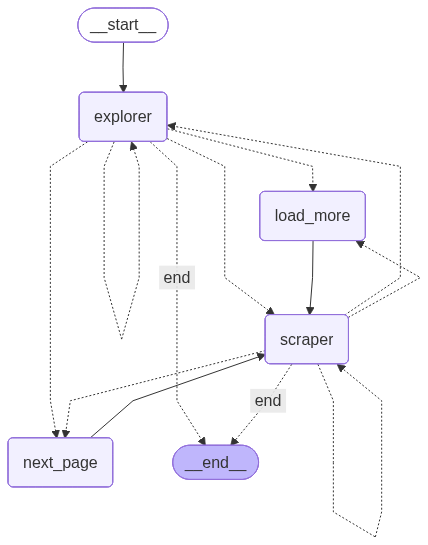

✅ Graph visualization displayed!


In [ ]:

try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
    print("✅ Graph visualization displayed!")
except:
    print("⚠️ Could not display graph visualization")

In [ ]:

async def run_article_scraper(target_url: str, target_count: int):
    """Execute the Article Scraper workflow with safety checks"""
    print(f"\n{'='*60}")
    print(f"🚀 Starting Article Scraper")
    print(f"Target: {target_count} articles from {target_url}")
    print(f"{'='*60}\n")

    initial_state = {
        "target_url": target_url,
        "target_count": target_count,
        "articles": [],
        "current_url": target_url,
        "page_content": "",
        "navigation_plan": "",
        "next_action": "explorer",  # Start with explorer
        "error_message": "",
        "retry_count": 0,
        "messages": []
    }

    # Add safety timeout and recursion limit
    try:
        # Run the graph with a timeout and recursion limit
        final_state = await asyncio.wait_for(
            app.ainvoke(initial_state, config={"recursion_limit": 100}),
            timeout=600.0  # 10 minutes timeout
        )
    except asyncio.TimeoutError:
        print("⚠️ Workflow timed out after 10 minutes")
        # Return current state even if incomplete
        final_state = initial_state
        final_state["error_message"] = "Workflow timed out"
    except Exception as e:
        print(f"⚠️ Workflow error: {str(e)}")
        # Return current state even if incomplete
        final_state = initial_state
        final_state["error_message"] = str(e)

    print(f"\n{'='*60}")
    print(f"✅ Article Scraper Completed")
    print(f"{'='*60}\n")

    return final_state

def run_scraper_sync(target_url: str, target_count: int):
    """Synchronous wrapper for the async scraper"""
    # Get the current event loop or create a new one
    try:
        loop = asyncio.get_event_loop()
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)

    # Run the async function
    return loop.run_until_complete(run_article_scraper(target_url, target_count))

print("✅ Enhanced article scraper function defined!")

✅ Enhanced article scraper function defined!


In [ ]:

# Run the article scraper for gemengserv.com
print("🚀 Starting enhanced article scraper...")
result = run_scraper_sync(
    target_url="https://gemengserv.com",
    target_count=25
)

# Display results
print(f"\n📋 FINAL RESULTS:")
print(f"Articles collected: {len(result['articles'])}")
print(f"Target: {result['target_count']}")
print(f"Final URL: {result['current_url']}")

# Check if we found any articles
if len(result['articles']) == 0:
    print("\n❌ No articles found!")
    print(f"Error message: {result.get('error_message', 'Unknown error')}")

    # Display navigation plan for debugging
    try:
        nav_plan = json.loads(result['navigation_plan'])
        print(f"\n🗺️ Navigation Plan:")
        print(f"Menu item to click: {nav_plan.get('menu_item_to_click', 'None')}")
        print(f"Strategy: {nav_plan.get('strategy', 'Unknown')}")
        print(f"Confidence: {nav_plan.get('confidence', 0)}")
    except:
        print(f"\n🗺️ Navigation Plan: {result['navigation_plan']}")
else:
    # Display navigation plan
    try:
        nav_plan = json.loads(result['navigation_plan'])
        print(f"\n🗺️ Navigation Plan:")
        print(f"Menu item to click: {nav_plan.get('menu_item_to_click', 'None')}")
        print(f"Strategy: {nav_plan.get('strategy', 'Unknown')}")
        print(f"Confidence: {nav_plan.get('confidence', 0)}")
    except:
        print(f"\n🗺️ Navigation Plan: {result['navigation_plan']}")

# Display messages
print(f"\n📝 Execution Log:")
for msg in result['messages']:
    print(f"- {msg['role']}: {msg['content']}")

# Display first few articles if any were found
if len(result['articles']) > 0:
    print("\nFirst 5 articles:")
    for i, article in enumerate(result['articles'][:5]):
        print(f"\nArticle {i+1}:")
        print(f"Title: {article.get('title', 'No title')}")
        print(f"Author: {article.get('author', 'Unknown')}")
        print(f"Date: {article.get('date', 'Unknown date')}")
        print(f"URL: {article.get('url', 'No URL')}")
        print(f"Content preview: {article.get('content', '')[:200]}...")

# Save results to JSON
with open('gemengserv_articles.json', 'w') as f:
    json.dump(result['articles'], f, indent=2)

print(f"\n✅ Results saved to gemengserv_articles.json")

🚀 Starting enhanced article scraper...

🚀 Starting Article Scraper
Target: 25 articles from https://gemengserv.com

🔵 Explorer Agent: Analyzing website structure...
🔵 Attempt 1/3 to load https://gemengserv.com
🔵 Found 56 menu items
🔵 Found 1 article links
🔵 Headings: ['Construction Project Management Consultancy', 'Projects Worldwide', 'Metric ton of Rebar Detailing and BBS', 'Million Sq. Ft. of Quantity Takeoff', 'Projects third Party QC provided']
🔵 Using LLM to analyze menu items...
🔵 LLM selected menu item: GEM Articles
🔵 Trying LLM-selected menu item: GEM Articles
🔵 Navigated to: https://gemengserv.com/
🔵 Validation: Found 1 article links (min required: 5)
🔵 Page doesn't have enough articles, going back
🔵 Trying fallback options...
🔵 Trying fallback option (priority 10): GEM Articles
🔵 Navigating to: https://gemengserv.com/gem-articles/
🔵 Validation: Found 10 article links (min required: 5)
🔵 Found valid articles page: https://gemengserv.com/gem-articles/
🔀 Decision Logic:
  - Nex